# USING A RESNET 3D FOR ALZHEIMER DIAGNOSIS



In [0]:
! pip install simpleitk

In [0]:
import tensorflow as tf
import numpy as np
import SimpleITK as sitk

from tensorflow import keras
from skimage import filters
from sklearn import metrics as skmetrics
from matplotlib import pyplot as plt

#from dltk.io import preprocessing
from scipy import interp
from itertools import cycle

import os
import json

In [0]:
from importlib.machinery import SourceFileLoader
keras_resnet3d = '/content/drive/MyDrive/Libraries/keras-resnet3d/'
resnet3d = SourceFileLoader('resnet3d', os.path.join(keras_resnet3d, 'resnet3d/resnet3d.py')).load_module()
from resnet3d import Resnet3DBuilder

---

## USING MRI IMAGES

In [0]:
# 3D supervised TFRecords databases
DB_TF_3D_PATH = '/content/drive/MyDrive/TF_RECORDS/TF_RECORDS_3D/'

# path where we save all the information about the models, like the training results
DB_MODELS = '/content/drive/MyDrive/MODELS/resnet_3d/'


# skull-stripped files
TFREC_3D_SS_TRAIN = 'train.3D.skull_stripped.tfrecords'
TFREC_3D_SS_VAL = 'validation.3D.skull_stripped.tfrecords'
TFREC_3D_SS_TEST = 'test.3D.skull_stripped.tfrecords'

Also, create constants with the shape of the images and a dictionary with the class labels.

In [0]:
LABELS = {'CN': 0, 'MCI': 1, 'AD': 2}
N_CLASSES = len(LABELS)

IMG_SHAPE = (78, 110, 86, 1)

#TEST_SPLIT = 0.15
#VALIDATION_SPLIT = 0.15

---

### Checking TFRecords data


In [0]:
training_tfrec = os.path.join(DB_TF_3D_PATH, TFREC_3D_SS_TRAIN)
validation_tfrec = os.path.join(DB_TF_3D_PATH, TFREC_3D_SS_VAL)
test_tfrec = os.path.join(DB_TF_3D_PATH, TFREC_3D_SS_TEST)

Load the number of instances for each set (training/validation/test). These have already been calculated in previous steps, so in the next cell we directly assign their values:

In [0]:
total_n_samples = 2294
n_training_samples = 1658
n_val_samples = 292
n_test_samples = 344

---

### Previous steps

#### Importing TFRecords

In [2]:
SHUFFLE_BUFFER = 100

In [0]:
def _decode(serialized_example):
    ''' Decoding function for the serialized examples
        of the TFRecords files
    '''
    # decode examples stored in TFRecord
    feature = tf.parse_single_example(
        serialized_example,
        features = {
            'image': tf.FixedLenFeature(IMG_SHAPE, tf.float32),
            'label': tf.FixedLenFeature([], tf.int64),
            'subject': tf.FixedLenFeature([], tf.string),
            'preprocessing': tf.FixedLenFeature([], tf.string),
            'subject_sex': tf.FixedLenFeature([], tf.string),
            'subject_age': tf.FixedLenFeature([], tf.int64),
            'image_id': tf.FixedLenFeature([], tf.int64)
        }
    )
    
    return feature['image'], feature['label']

In [0]:
def dataset_parser(filepath, batch_size, mapping_fn=None, preprocessing_fn=None, n_classes=3):
  ''' This method is a pipeline for feeding
      tfrecord data into a Keras model.
      
      Parameters:
        filepath -- The complete path to the TFRecord file
        batch_size -- The size of the batch
        mapping_fn -- Function for extra mapping the values. 
                      For adapting the records to binary classification.
        preprocessing_fn -- Function for image preprocessing
        n_classes -- Number of possible classes for the current implementation
        
      Returns:
        image -- Tensor with the image
        label -- Tensor with the label
  '''
  
  # create and configure the dataset
  dataset = tf.data.TFRecordDataset(filepath).map(_decode)
  if mapping_fn != None: dataset = dataset.map(mapping_fn)
  if preprocessing_fn != None: dataset = dataset.map(preprocessing_fn)
    
  dataset = dataset.shuffle(SHUFFLE_BUFFER).repeat()
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(1)
  
  # get example
  iterator = dataset.make_one_shot_iterator()
  image, label = iterator.get_next()
  
  # encode the label
  label = tf.one_hot(label, n_classes)
  
  return image, label

In [0]:
whitening_fn = lambda img, label: (tf.image.per_image_standardization(img), label) 

#### VIsualization function

In [0]:
def plot_training(history, title):
  ''' Plot the training and validation loss + accuracy
  '''
  
  acc = history.history['acc'][1:]
  val_acc = history.history['val_acc'][1:]
  loss = history.history['loss'][1:]
  val_loss = history.history['val_loss'][1:]
  epochs = range(len(acc))
  
  plt.figure(figsize=(20, 8))

  plt.subplot(121)
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.legend(('Training accuracy', 'Validation accuracy'),
             loc='upper right')
  plt.title(title + '- Accuracy')

  plt.subplot(122)
  plt.plot(epochs, loss, 'b.')
  plt.plot(epochs, val_loss, 'b')
  plt.legend(('Training loss', 'Validation loss'),
             loc='upper right')
  plt.title(title)
  
  export_file = '-'.join(title.split()) + '.png'
  plt.savefig(os.path.join(DB_MODELS, export_file))
  
  plt.show()

#### Testing functions

In [0]:
def get_data_for_predict(tfrec_file, decoding_fn, mapping_fn=None, preprocessing_fn=None):
  ''' Read and return the data from a TFRecord file.
      This function is only ready for working with test data.
      
      Params:
        tfrec_file -- Absolute path to the .tfrecord
        decoding_fn - Function used to decode the serialized examples
        mapping_fn -- Optional extra mapping for binary classification
        preprocessing_fn -- Function for image preprocessing
      
      Returns:
        images and labels (tuple)
  '''
  
  # create the placeholders
  images = np.empty((n_test_samples, IMG_SHAPE[0], IMG_SHAPE[1], IMG_SHAPE[2], IMG_SHAPE[3]))
  labels = np.empty((n_test_samples))

  # create the iterator for the TFRecord
  dataset = tf.data.TFRecordDataset(tfrec_file).map(decoding_fn)
  if mapping_fn != None: dataset = dataset.map(mapping_fn)
  if preprocessing_fn != None: dataset = dataset.map(preprocessing_fn)
  iterator = dataset.make_one_shot_iterator()
  next_record = iterator.get_next()

  # init a session, copying the information to the placeholders
  i = 0
  with tf.Session() as sess:
    while i < n_test_samples:
      images[i,], labels[i] = sess.run(next_record)
      i += 1
      
  return images, labels

In [0]:
def compute_auc(model, images, labels, target_names, title):
  ''' Computes the ROC and AUC for a given model
      and a specific test set.
      
      Parameters:
        model -- The trained model
        images -- Images of the test set
        labels -- Labels for the images
        target_names -- Names for the labels
  '''
  n_classes = len(target_names)
  y_true = tf.keras.utils.to_categorical(labels, n_classes)
  y_pred = model.predict(x=images)
  
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
    fpr[i], tpr[i], _ = skmetrics.roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = skmetrics.auc(fpr[i], tpr[i])
  
  # compute micro-average ROC curve and ROC area
  fpr['micro'], tpr['micro'], _ = skmetrics.roc_curve(y_true.ravel(), y_pred.ravel())
  roc_auc['micro'] = skmetrics.auc(fpr['micro'], tpr['micro'])
  
  # compute macro-average ROC curve and ROC area
  # first aggregate all false positive rates
  all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

  # Then interpolate all ROC curves at this points
  mean_tpr = np.zeros_like(all_fpr)
  for i in range(n_classes):
      mean_tpr += interp(all_fpr, fpr[i], tpr[i])

  # finally average it and compute AUC
  mean_tpr /= n_classes

  fpr['macro'] = all_fpr
  tpr['macro'] = mean_tpr
  roc_auc['macro'] = skmetrics.auc(fpr['macro'], tpr['macro'])

  # plot all ROC curves
  plt.figure(figsize=(10, 10))
  plt.plot(fpr['micro'], tpr['micro'],
           label='micro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc['micro']),
           color='deeppink', linestyle=':', linewidth=4)

  plt.plot(fpr['macro'], tpr['macro'],
           label='macro-average ROC curve (area = {0:0.2f})'
                 ''.format(roc_auc["macro"]),
           color='navy', linestyle=':', linewidth=4)

  colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=2,
               label='ROC curve of class {0} (area = {1:0.2f})'
               ''.format(target_names[i], roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--', lw=2)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(title)
  plt.legend(loc="lower right")
  
  export_file = '-'.join(title.split()) + '.png'
  plt.savefig(os.path.join(DB_MODELS, export_file))
  
  plt.show()

In [0]:
def classification_report(model, images, labels, target_names, output_file):
  ''' Prints the classification report for a given model and
      a specific test set. Exports it to a .json file
      
      Parameters:
        model -- The trained model
        images -- Images of the test set
        labels -- Labels of the images
        target_names -- Names of the labels
        output_file -- Name and path of the output json file
  '''
  
  n_classes = len(target_names)
  y_true = tf.keras.utils.to_categorical(labels, n_classes)
  predictions = model.predict(x=images)
  
  output = skmetrics.classification_report(labels, predictions.argmax(axis=1), 
                                           target_names=target_names, output_dict=True)
  print(json.dumps(output, indent=4))
  
  with open(os.path.join(DB_MODELS, output_file + '.json'), 'w') as output_json:
    json.dump(output, output_json, indent=4)

---
### MULTICLASS CLASSIFICATION MODEL


In [0]:
BATCH_SIZE = 8
STEPS_PER_EPOCH = int(n_training_samples / BATCH_SIZE)
VALIDATION_STEPS = int(n_val_samples / BATCH_SIZE)

In [0]:
image_tensor, label_tensor = dataset_parser(training_tfrec, BATCH_SIZE, preprocessing_fn=whitening_fn)

In [0]:
base_model = Resnet3DBuilder.build_resnet_34(
    input_shape=IMG_SHAPE,
    num_outputs=N_CLASSES,
    reg_factor=0.01
)

fc_layer = tf.keras.layers.Dense(512, activation='relu')(base_model.layers[-2].output)
fc_layer = tf.keras.layers.Dropout(0.8)(fc_layer)
output_layer = tf.keras.layers.Dense(N_CLASSES, activation='softmax')(fc_layer)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output_layer)

In [0]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, 
              loss='categorical_crossentropy', 
              metrics=['acc'])



#### Training


In [0]:
val_tensor = dataset_parser(validation_tfrec, BATCH_SIZE, preprocessing_fn=whitening_fn) 

In [0]:
class EarlyStoppingByLossVal(tf.keras.callbacks.Callback):
  ''' Define an early stopping callback to stop training
      when a certain validation loss value is achieved.
  '''
  
  def __init__(self, monitor='val_loss', value=1.4, verbose=0):
    ''' Initialization '''
    super(tf.keras.callbacks.Callback, self).__init__()
    self.monitor = monitor
    self.value = value
    self.verbose = verbose

  def on_epoch_end(self, epoch, logs={}):
    ''' Check, on epoch end, if the validation loss
        value is smaller than the threshold
    '''
    current = logs.get(self.monitor)
    if current is None:
      warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

    if current < self.value:
      if self.verbose > 0:
        print("Epoch %05d: early stopping THR" % epoch)
      self.model.stop_training = True

In [0]:
callback = EarlyStoppingByLossVal(value=1.1)

In [54]:
history = model.fit(x=image_tensor, y=label_tensor, 
                    epochs=20, steps_per_epoch=STEPS_PER_EPOCH, 
                    validation_data=val_tensor, 
                    validation_steps=VALIDATION_STEPS,
                    callbacks=[callback])

Epoch 1/20
286/286 [==============================] - 443s 2s/step - loss: 9.0802 - acc: 0.4655 - val_loss: 1.2705 - val_acc: 0.5525
Epoch 2/20
286/286 [==============================] - 427s 1s/step - loss: 1.2964 - acc: 0.4965 - val_loss: 1.8171 - val_acc: 0.5525
Epoch 3/20
286/286 [==============================] - 427s 1s/step - loss: 1.3012 - acc: 0.5039 - val_loss: 1.2264 - val_acc: 0.5175
Epoch 4/20
286/286 [==============================] - 427s 1s/step - loss: 1.4621 - acc: 0.5070 - val_loss: 1.1464 - val_acc: 0.5425
Epoch 5/20
286/286 [==============================] - 427s 1s/step - loss: 1.1430 - acc: 0.5114 - val_loss: 1.1444 - val_acc: 0.5075
Epoch 6/20
286/286 [==============================] - 427s 1s/step - loss: 2.2860 - acc: 0.5026 - val_loss: 1.5342 - val_acc: 0.5600
Epoch 7/20
286/286 [==============================] - 417s 1s/step - loss: 1.1193 - acc: 0.5092 - val_loss: 1.0574 - val_acc: 0.5000


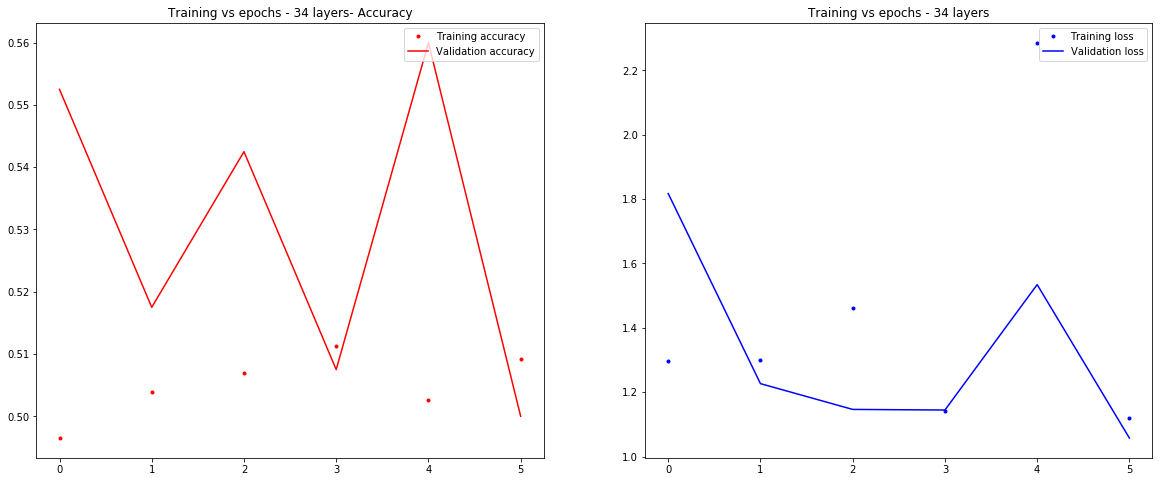

In [55]:
plot_training(history, 'Training vs epochs - 34 layers')



#### Saving and loading

Save the model at this point:

In [0]:
MC_CHECKPOINT = 'multiclass_resnet_34_3d_trained_regfactor003'

In [0]:
model_file = os.path.join(DB_MODELS, MC_CHECKPOINT) + '.h5'

In [0]:
model.save(model_file)

For loading, run the following cell:

In [0]:
model = tf.keras.models.load_model(model_file)

#### Testing

In [0]:
images, labels = get_data_for_predict(test_tfrec, _decode, preprocessing_fn=whitening_fn)

In [56]:
classification_report(model, images, labels, LABELS, 'classification_report - 34 layers')

{
    "CN": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 131
    },
    "MCI": {
        "precision": 0.5315126050420168,
        "recall": 1.0,
        "f1-score": 0.6941015089163238,
        "support": 253
    },
    "AD": {
        "precision": 0.0,
        "recall": 0.0,
        "f1-score": 0.0,
        "support": 92
    },
    "accuracy": 0.5315126050420168,
    "macro avg": {
        "precision": 0.17717086834733894,
        "recall": 0.3333333333333333,
        "f1-score": 0.2313671696387746,
        "support": 476
    },
    "weighted avg": {
        "precision": 0.28250564931855093,
        "recall": 0.5315126050420168,
        "f1-score": 0.36892370116770995,
        "support": 476
    }
}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


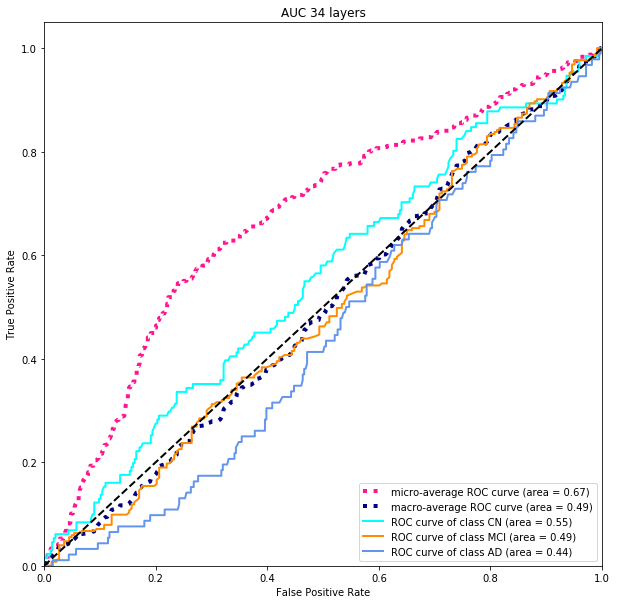

In [57]:
compute_auc(model, images, labels, ['CN', 'MCI', 'AD'], title='AUC 34 layers')